In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Function
from torch.utils.data import DataLoader, Dataset
import numpy as np
from helper import *
import random


In [2]:
sequences_list = getData("Data/rbcL_one_hot_encoding.txt", 50000)

In [3]:
print(sequences_list.shape)
print(sequences_list[0].shape)

(50000, 300, 5)
(300, 5)


In [4]:
sequences = torch.from_numpy(sequences_list).clone().detach().float()
sequences = sequences.permute(0, 2, 1)

In [5]:
def cosine_distance(x, y, dim=1):
    return 1 - torch.nn.functional.cosine_similarity(x, y, dim)

class ConvolutionalNet(nn.Module):
    def __init__(self):
        super(ConvolutionalNet, self).__init__()
        self.C1 = torch.nn.Conv1d(5, 64, kernel_size=3, stride=1, padding=1)

        self.R1 = torch.nn.ReLU()
        self.MaxPool1 = torch.nn.MaxPool1d(kernel_size=2, stride=1)

        self.C2 = torch.nn.Conv1d(64, 64, kernel_size=3, stride=1, padding=1)

        self.R2 = torch.nn.ReLU()
        self.MaxPool2 = torch.nn.MaxPool1d(kernel_size=2, stride=1)

        self.Lin =  nn.Linear(64 * 298, 128)
       
    
    def forward(self, input):
        x = self.C1(input)
        x = self.R1(x)
        x = self.MaxPool1(x)

        x = self.C2(x)
        x = self.R2(x)
        x = self.MaxPool2(x)

        x = x.view(-1, 19072)
        x = self.Lin(x)
 
        return x

class DNADataset(Dataset):
    def __init__(self, sequences):
        self.sequences = sequences

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return torch.FloatTensor(self.sequences[idx])

model = ConvolutionalNet()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CosineEmbeddingLoss()

epochs = 20
batch_size = 32
dataset = DNADataset(sequences)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

criterion = nn.MSELoss()

# for epoch in range(epochs):
#     model.train()
#     for batch in dataloader:
#         x1, x2 = torch.chunk(batch, 2, dim=0)

#         optimizer.zero_grad()

#         target = cosine_distance(x1.view(x1.shape[0], -1), x2.view(x1.shape[0], -1), dim = 1)


#         output1 = model.forward(x1)
#         output2 = model.forward(x2)

#         result = cosine_distance(output1, output2, dim = 1)

#         loss = criterion(target, result)
#         loss.backward()
#         optimizer.step()


#     print(f"Batch loss is {loss}")
#     print(f"epoch {epoch} is done")

# torch.save(model.state_dict(), 'Conv1d.pth')


In [6]:
model = ConvolutionalNet()
model.load_state_dict(torch.load('Conv1d.pth'))
model.eval()

ConvolutionalNet(
  (C1): Conv1d(5, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (R1): ReLU()
  (MaxPool1): MaxPool1d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
  (C2): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (R2): ReLU()
  (MaxPool2): MaxPool1d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
  (Lin): Linear(in_features=19072, out_features=128, bias=True)
)

In [7]:
print(sequences.shape)
print(sequences_list.shape)

torch.Size([50000, 5, 300])
(50000, 300, 5)


In [8]:
sequences_flat = getData("Data/rbcL_ordinal_encoding.txt", 50000)

In [9]:
print(sequences_flat.shape)

(50000, 300)


In [10]:
num_clusters = pairWiseCrossValidation(sequences, sequences_flat, model)

Label 0: Count 2902
Label 1: Count 44351
Label 2: Count 2747
Label 0: Count 2747
Label 1: Count 13284
Label 2: Count 31067
Label 3: Count 2902
Label 0: Count 1441
Label 1: Count 30753
Label 2: Count 13318
Label 3: Count 1741
Label 4: Count 2747
Label 0: Count 1741
Label 1: Count 32596
Label 2: Count 2747
Label 3: Count 10503
Label 4: Count 972
Label 5: Count 1441
Label 0: Count 2747
Label 1: Count 3257
Label 2: Count 7324
Label 3: Count 4873
Label 4: Count 28617
Label 5: Count 1441
Label 6: Count 1741
Label 0: Count 26308
Label 1: Count 5826
Label 2: Count 1252
Label 3: Count 2747
Label 4: Count 8124
Label 5: Count 1441
Label 6: Count 1741
Label 7: Count 2561
Label 0: Count 1161
Label 1: Count 30586
Label 2: Count 1441
Label 3: Count 2747
Label 4: Count 9810
Label 5: Count 743
Label 6: Count 1741
Label 7: Count 799
Label 8: Count 972
Label 0: Count 1441
Label 1: Count 19356
Label 2: Count 4372
Label 3: Count 6985
Label 4: Count 2942
Label 5: Count 2747
Label 6: Count 7318
Label 7: Coun

In [11]:
print(num_clusters)

9


In [12]:
num_clusters = 9

In [13]:
cluster_labels, unique_labels = KMeansOnEmbeddings(sequences, model, num_clusters)

Label 0: Count 1161
Label 1: Count 30586
Label 2: Count 1441
Label 3: Count 2747
Label 4: Count 9810
Label 5: Count 743
Label 6: Count 1741
Label 7: Count 799
Label 8: Count 972


In [14]:
sequences = sequences.permute(0, 2, 1)

In [15]:
decodeSequences("conv1d", sequences, one_hot_decoder, unique_labels, cluster_labels)

In [25]:
runClustalRange("conv1d", 0, num_clusters, unique_labels, True)

Using 16 threads
Read 1161 sequences (type: DNA) from clusters/conv1d/cluster_0.fasta
Using 103 seeds (chosen with constant stride from length sorted seqs) for mBed (from a total of 1161 sequences)
Calculating pairwise ktuple-distances...
Ktuple-distance calculation progress: 0 % (0 out of 114330)
Ktuple-distance calculation progress: 13 % (15859 out of 114330)
Ktuple-distance calculation progress: 14 % (16386 out of 114330)
Ktuple-distance calculation progress: 15 % (17262 out of 114330)
Ktuple-distance calculation progress: 16 % (18585 out of 114330)
Ktuple-distance calculation progress: 17 % (19752 out of 114330)
Ktuple-distance calculation progress: 18 % (20786 out of 114330)
Ktuple-distance calculation progress: 28 % (32940 out of 114330)
Ktuple-distance calculation progress: 29 % (33330 out of 114330)
Ktuple-distance calculation progress: 30 % (34639 out of 114330)
Ktuple-distance calculation progress: 31 % (36111 out of 114330)
Ktuple-distance calculation progress: 32 % (36647 o

In [16]:
percentages = evaluateGapsInRange("conv1d", 0, num_clusters, unique_labels)

clustal/conv1d/cluster_0.clustal
Percentage of gaps in the alignment for cluster 0: 0.84%
clustal/conv1d/cluster_1.clustal
Percentage of gaps in the alignment for cluster 1: 81.74%
clustal/conv1d/cluster_2.clustal
Percentage of gaps in the alignment for cluster 2: 0.84%
clustal/conv1d/cluster_3.clustal
Percentage of gaps in the alignment for cluster 3: 0.84%
clustal/conv1d/cluster_4.clustal
Percentage of gaps in the alignment for cluster 4: 76.31%
clustal/conv1d/cluster_5.clustal
Percentage of gaps in the alignment for cluster 5: 0.83%
clustal/conv1d/cluster_6.clustal
Percentage of gaps in the alignment for cluster 6: 0.84%
clustal/conv1d/cluster_7.clustal
Percentage of gaps in the alignment for cluster 7: 0.84%
clustal/conv1d/cluster_8.clustal
Percentage of gaps in the alignment for cluster 8: 0.28%


In [27]:
print(countPercentageLowerThan(percentages, 10))

7


Plot for cluster 0


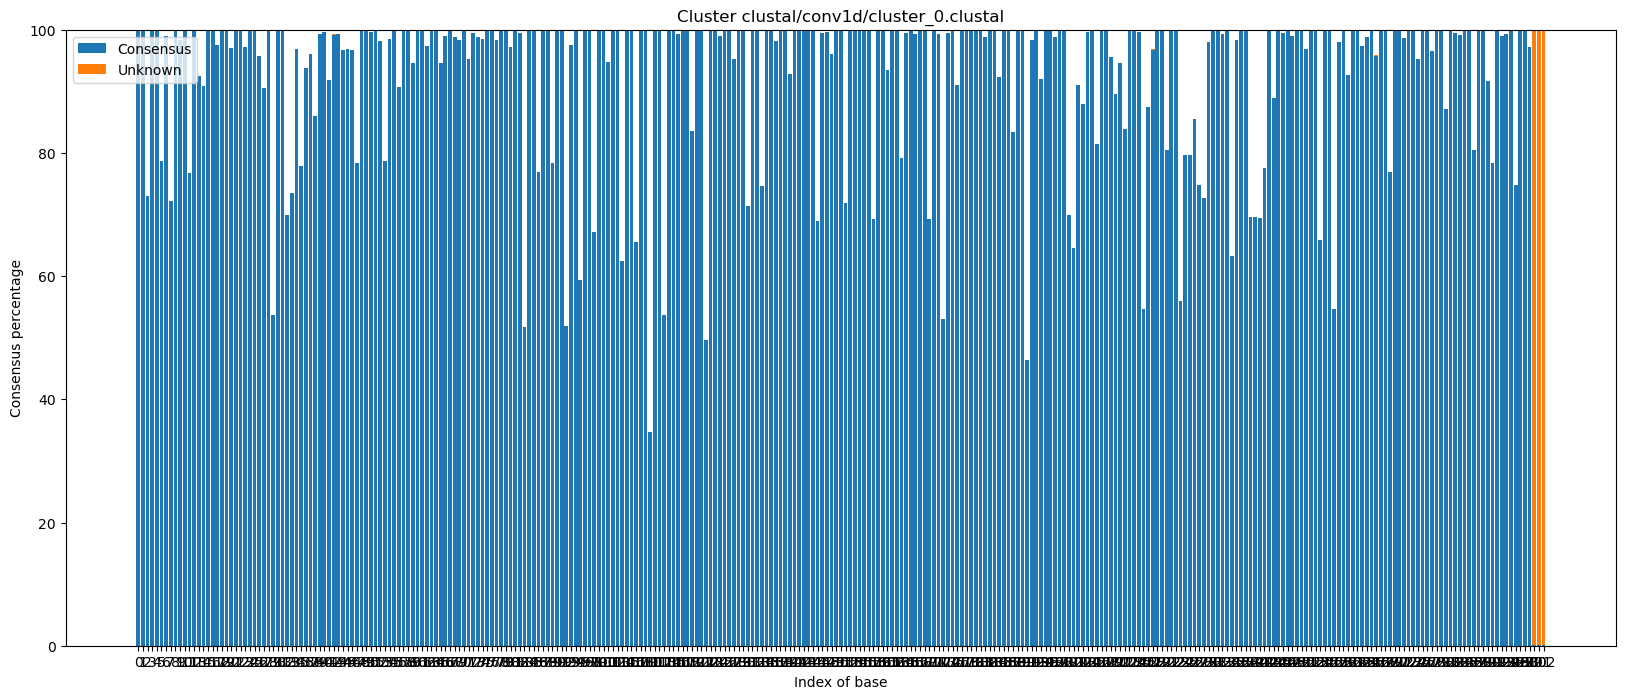

Plot for cluster 1


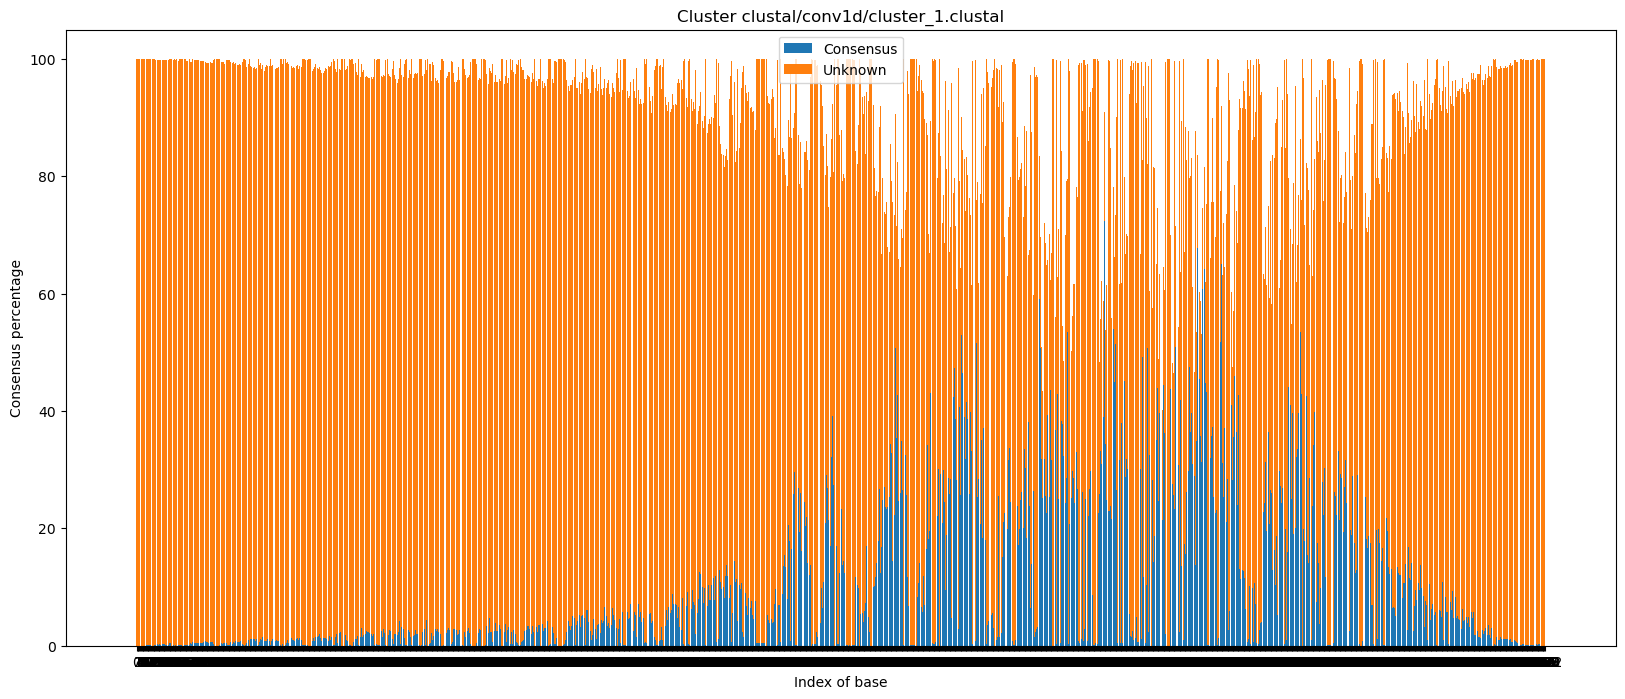

Plot for cluster 2


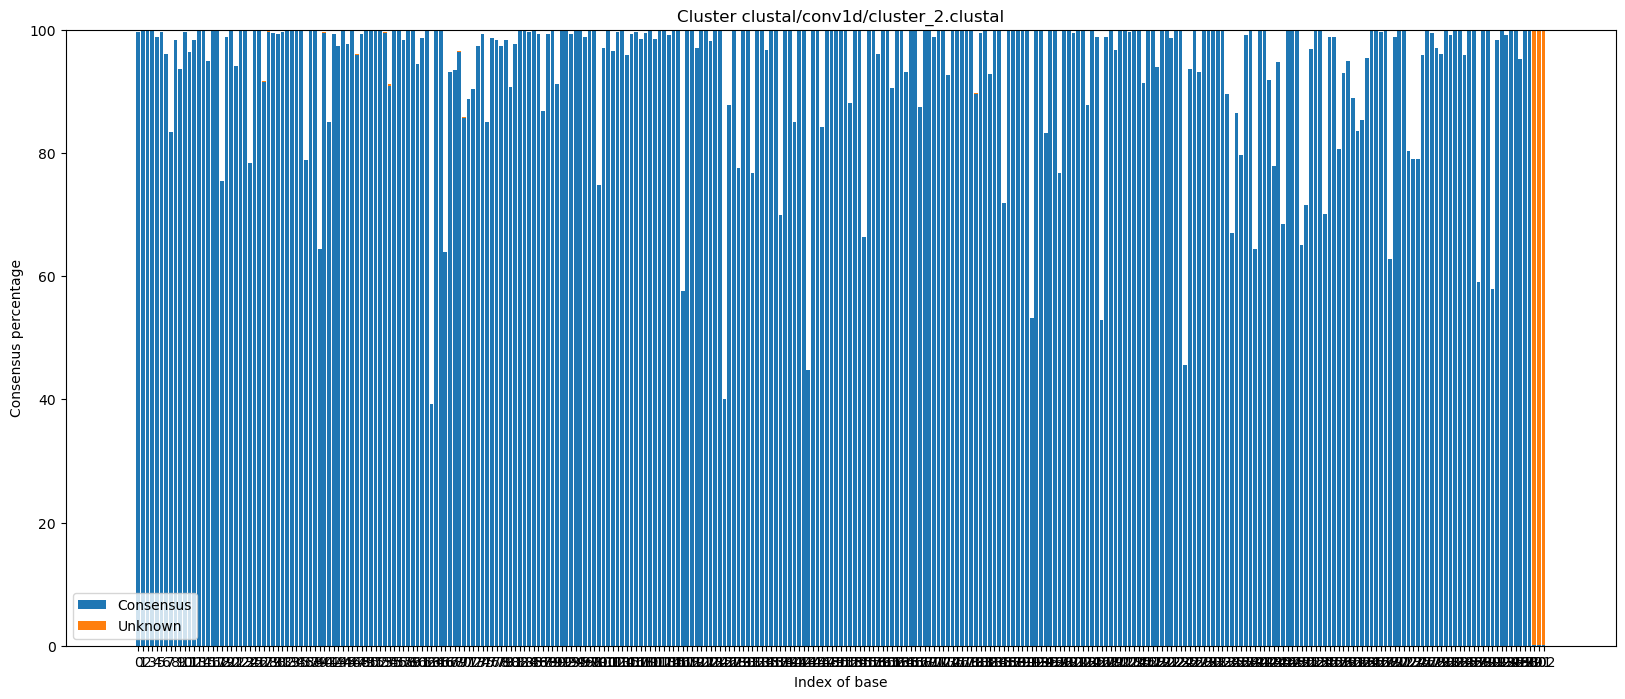

Plot for cluster 3


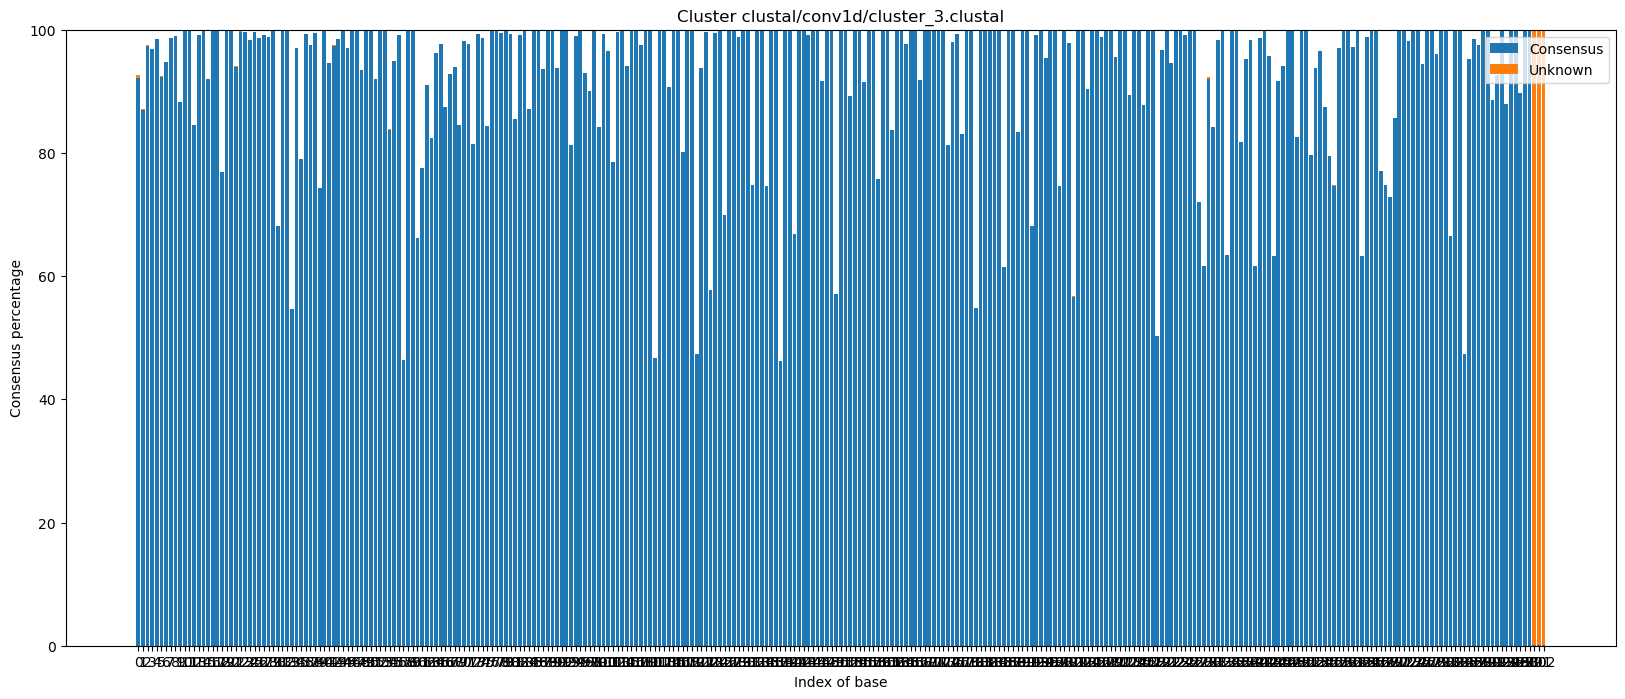

Plot for cluster 4


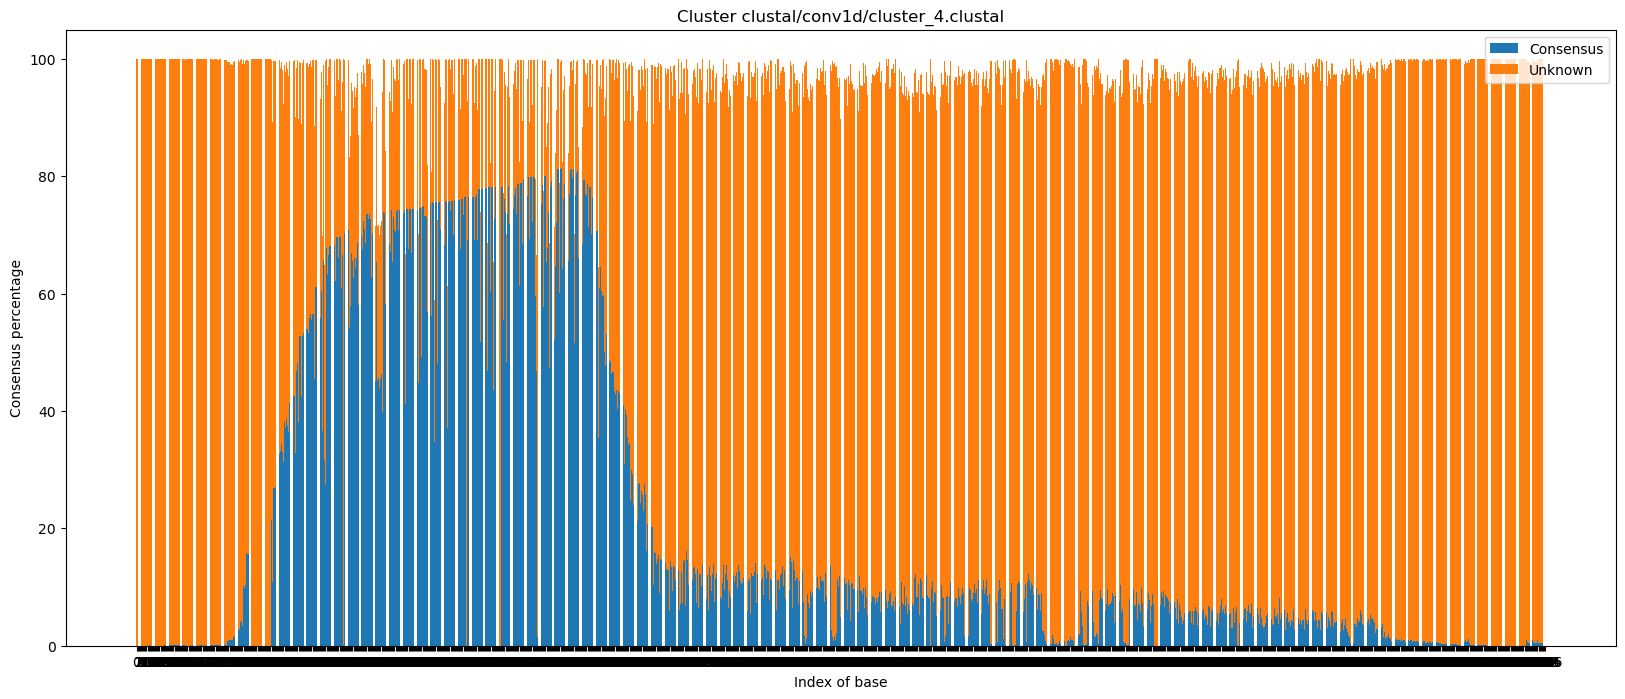

Plot for cluster 5


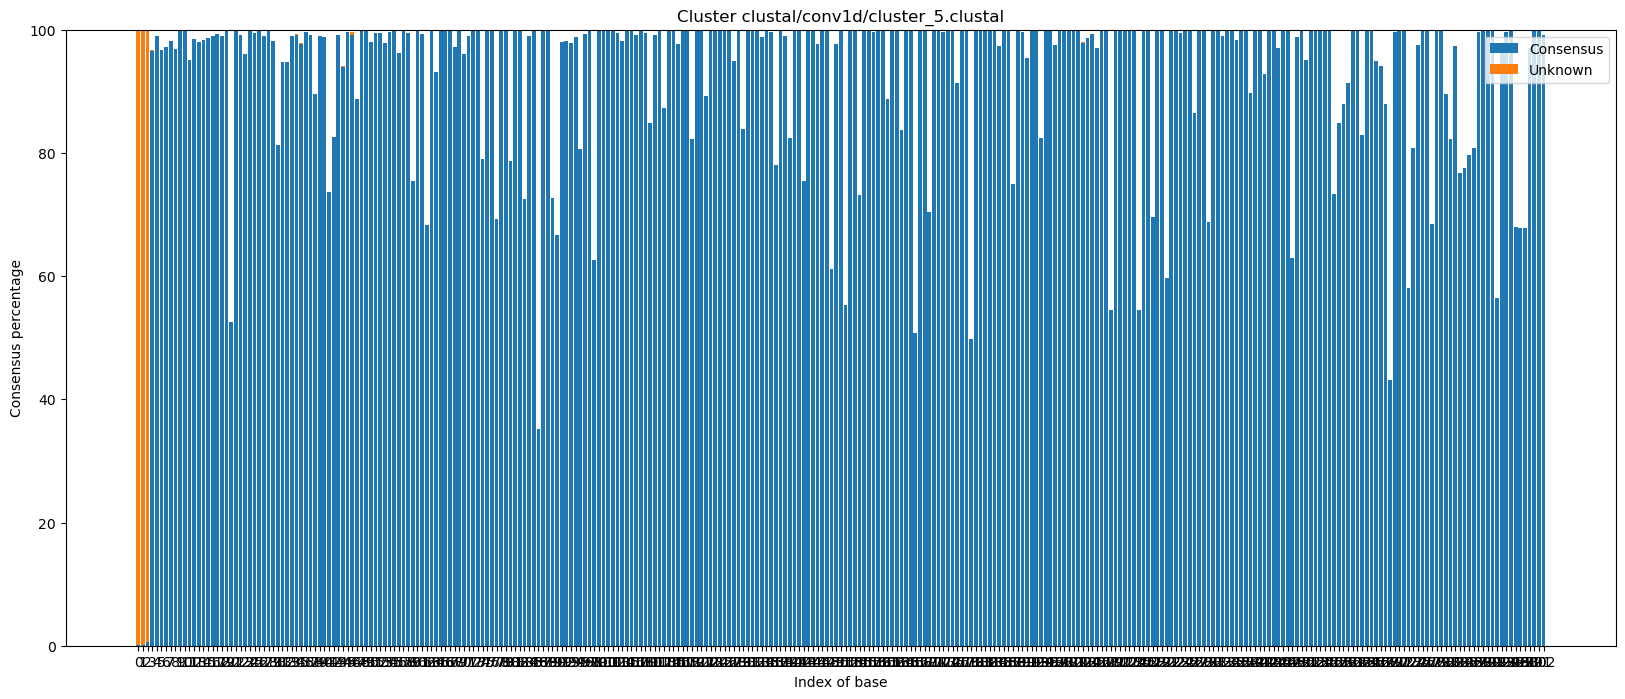

Plot for cluster 6


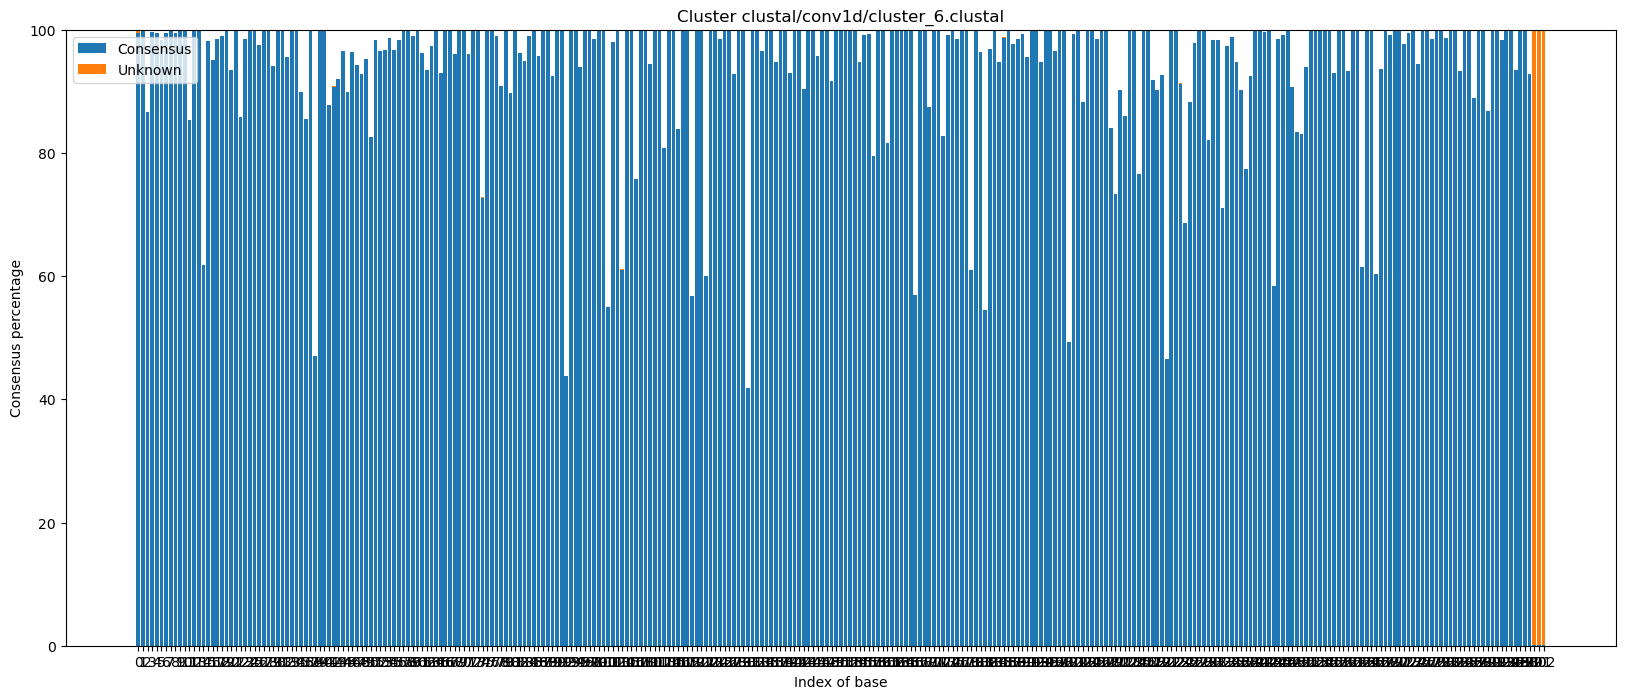

Plot for cluster 7


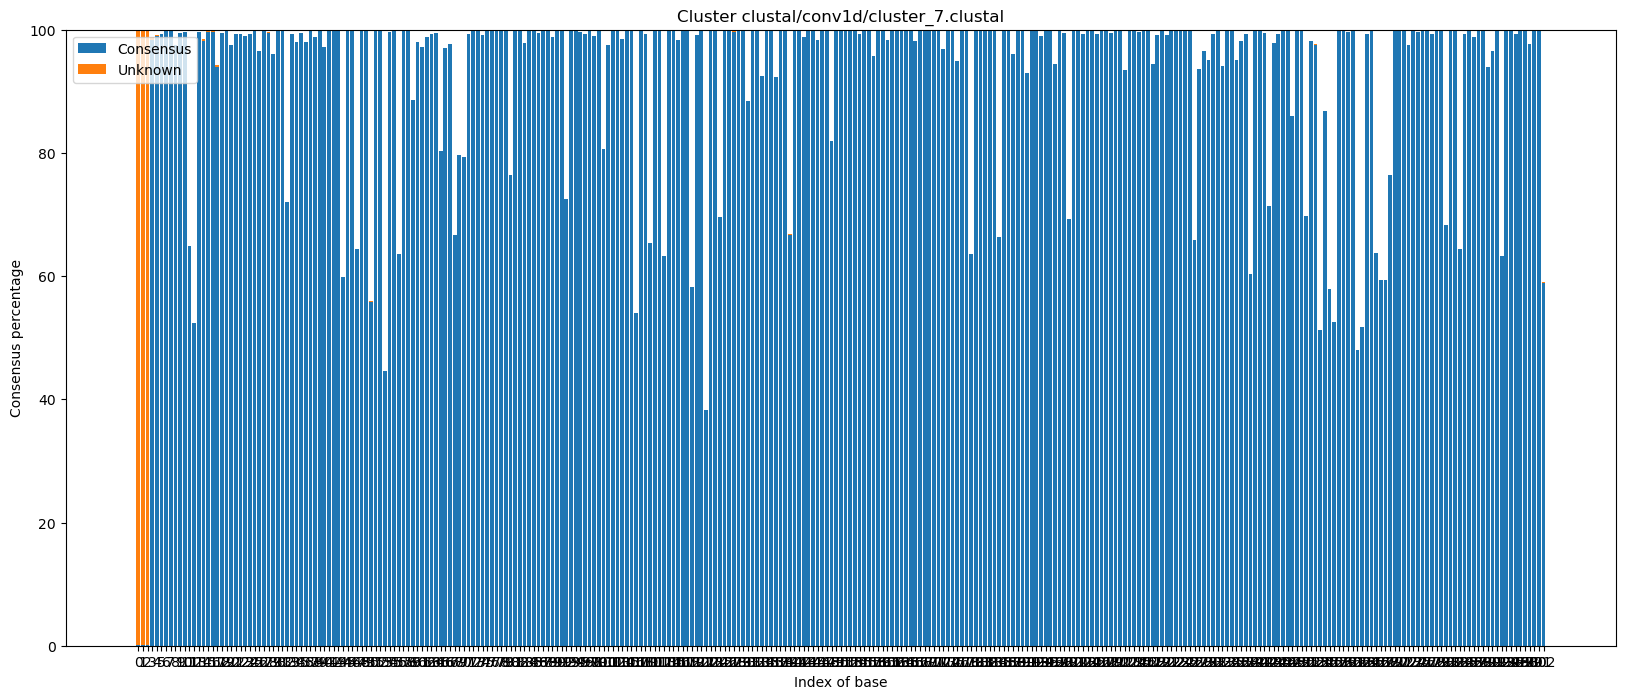

Plot for cluster 8


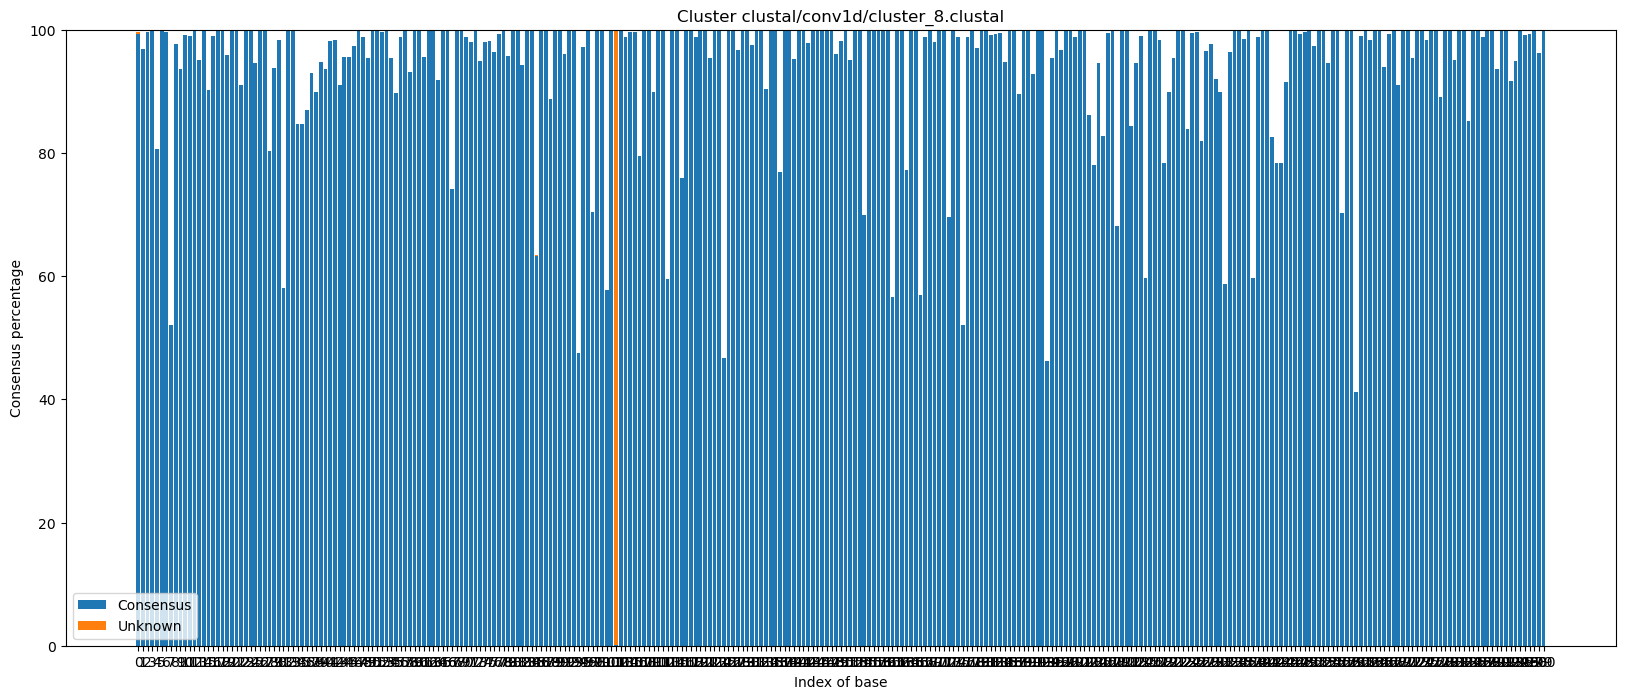

In [29]:
plotClusterRange("conv1d", 0, num_clusters, unique_labels)

In [17]:
print(np.mean(percentages))
print(np.median(percentages))
print(np.std(percentages))

18.150877182373428
0.8394160583941607
32.56335781866611


In [18]:
scores, normalized_scores, sum_scores, div_scores = primerExtractionScoreOnModel("conv1d", cluster_labels, unique_labels, stride=1)

In [19]:
print(scores)
print(normalized_scores)
print(sum_scores)
print(div_scores)

[96.41515934539191, 0, 97.32546842470506, 95.0578813250819, 73.0605504587156, 96.88559892328398, 96.44342331993107, 98.11514392991239, 96.82510288065843]
[ 2.23876  0.       2.80492  5.22248 14.33448  1.43972  3.35816  1.56788
  1.88228]
32.84868
3.6498533333333336


In [20]:
np.count_nonzero(normalized_scores)/len(unique_labels)

0.8888888888888888

In [21]:
sequences_list = list(SeqIO.parse("Data/rbcL.fasta" , "fasta"))
family_count_per_cluster, family_frequencies_per_cluster = getFamiliesPerCluster(cluster_labels, unique_labels, getIDs("Data/rbcL_ids.txt"), getIDFamilyMapping(sequences_list))

In [22]:
print(family_count_per_cluster)
print(family_frequencies_per_cluster)

{0: 521, 1: 8542, 2: 741, 3: 1006, 4: 3457, 5: 361, 6: 705, 7: 342, 8: 513}
{0: {'sativum': 1, 'variegata': 2, 'densata': 6, 'fanjingshanensis': 2, 'aestivum': 4, 'watanabei': 2, 'smithiana': 5, 'glaucescens': 1, 'cephalantha': 5, 'huangshanensis': 1, 'holophylla': 2, 'cyathophylloides': 2, 'communis': 2, 'sinensis': 3, 'heucherifolia': 1, 'jezoensis': 3, 'luzonicum': 1, 'laoshanensis': 4, 'wilsonii': 6, 'dichotoma': 3, 'batangensis': 3, 'grandiflora': 3, 'heteromera': 2, 'rupicola': 6, 'latum': 1, 'biglobosa': 33, 'duchartrei': 3, 'obovata': 6, 'sp.': 18, 'abies': 6, 'turbinata': 1, 'densiflora': 7, 'semi-infera': 7, 'beshanzuensis': 2, 'lobelioides': 2, 'basilicum': 1, 'griffithiana': 6, 'likiangensis': 24, 'futtereri': 1, 'nukiangensis': 3, 'enervis': 1, 'parviumbellata': 1, 'chinensis': 11, 'micranthum': 2, 'tongolensis': 4, 'lancifolia': 5, 'georgei': 4, 'lanceolatum': 1, 'straminea': 4, 'spina-christi': 1, 'anas': 2, 'dumicola': 3, 'cardiosepala': 4, 'europaea': 7, 'daltonii': 4,